# Imports

In [368]:
import string

In [369]:
import numpy as np

In [370]:
import pandas as pd

In [371]:
import matplotlib.pyplot as plt
import seaborn as sns

In [372]:
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, OneHotEncoder, StandardScaler, MaxAbsScaler, Normalizer, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD

In [373]:
from scipy.stats import randint, uniform

# Functions

In [374]:
def inspect_df(df : pd.DataFrame):
    """
    Display basic structural information about a DataFrame.

    This function prints the number of rows and columns, checks for
    missing values, and displays the data types of each feature.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to be inspected.

    Returns
    -------
    None
        This function does not return any value. It prints
        summary information to the console.

    Notes
    -----
    - If no missing values are present, the function explicitly
      prints that there are zero null values.
    - If missing values exist, the function prints the number
      of null values for each column.
    - Feature data types are displayed using `df.dtypes`.
    """
    print(f'Rows:       {df.shape[0]}')
    print(f'Columns:    {df.shape[1]}')
    print("-" * 30)

    null_values = df.isna().sum()
    if (null_values.sum() == 0):
        print('Null values: 0')
    else:
        print('Null values:')
        print(null_values)
    
    print("-" * 30)
    print('Feature data types:')
    print(df.dtypes)
    print("")

In [375]:
def check_balance(df : pd.DataFrame, target_col : str):
    """
    Check the class distribution of a target column in a dataset.

    This function computes the percentage distribution of each class
    in the specified target column and prints the results. It also
    displays the ideal percentage share per class for a perfectly
    balanced dataset.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing the dataset.
    target_col : str
        Name of the target column whose class distribution
        needs to be evaluated.

    Returns
    -------
    None
        This function does not return any value. It prints
        the class distribution and balance information.

    Notes
    -----
    - Percentages are computed using normalized value counts
      and rounded to two decimal places.
    - The dataset can be considered balanced if the class
      percentages are close to the ideal equal share
      (100 / number_of_classes).
    - The function assumes that `target_col` exists in `df`.
    """
    value_counts = (df[target_col].value_counts(normalize=True) * 100).round(2)
    ideal_share = 100 / len(value_counts)
    
    print(f'Value counts for {target_col}:')
    print(value_counts)
    print("-" * 30)
    print(f'The dataset is balanced if the value counts are close to {ideal_share:.2f}%')

In [376]:
def plot_scatter(df : pd.DataFrame, x_feature : str, y_feature : str):
    """
    Generate a scatter plot for two selected features from a DataFrame.

    This function creates a scatter plot using the specified columns
    as x and y axes and displays the plot.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing the data to be plotted.
    x_feature : str
        Name of the column to be used as the x-axis.
    y_feature : str
        Name of the column to be used as the y-axis.

    Returns
    -------
    None
        This function does not return any value. It displays the plot.

    Notes
    -----
    - The function assumes that both `x_feature` and `y_feature`
      exist in the provided DataFrame.
    - No additional styling or customization is applied to the plot.
    """
    plt.scatter(df[x_feature], df[y_feature])
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()

In [377]:
def evaluate_classifier(
        model, 
        x_test : pd.DataFrame, 
        y_test : pd.Series, 
        title: str, 
        f1_average: str = 'binary', 
        f1_pos_label = 1
    ):
    """
    Evaluate the performance of a classification model on a test dataset.

    This function computes Accuracy and F1-score, prints the results,
    and displays the confusion matrix normalized by rows.

    Parameters
    ----------
    model : estimator
        A trained classification model implementing the `predict` method.
    x_test : array-like
        Feature matrix of the test dataset.
    y_test : array-like
        True labels corresponding to `x_test`.
    title : str
        Descriptive title to display in the output and on the confusion matrix plot.
    f1_average : str, default='binary'
        Averaging method used to compute the F1-score.
        Common options include: 'binary', 'micro', 'macro', 'weighted'.
    f1_pos_label : int or str, default=1
        The label considered as the positive class when `f1_average='binary'`.

    Returns
    -------
    y_pred : array-like
        Predicted labels generated by the model on `x_test`.

    Notes
    -----
    - The confusion matrix is displayed normalized by rows (`normalize='true'`),
      meaning values represent proportions relative to the true class.
    - Metrics are printed with four decimal places.
    """
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average=f1_average, pos_label=f1_pos_label)

    print("")
    print(f"{title.title()}:")
    print(f"Accuracy:                   {accuracy:.4f}")
    print(f"F1 score ({f1_average}):        {f1:.4f}")

    disp = ConfusionMatrixDisplay.from_predictions(
        y_pred, y_test,
        cmap=plt.cm.Blues, 
        normalize='true'    # 'true' normalize on rows
    )
    disp.ax_.set_title(title.title())
    plt.show()

    return y_pred

In [378]:
def evaluate_regressor(model, x_test : pd.DataFrame, y_test : pd.Series):
    """
    Evaluate the performance of a regression model on a test dataset.

    This function generates predictions using the provided model and
    computes common regression metrics: MAE, MSE, MSLE (if applicable),
    and R² score. The results are printed to the console.

    Parameters
    ----------
    model : estimator
        A trained regression model implementing the `predict` method.
    x_test : array-like
        Feature matrix of the test dataset.
    y_test : array-like
        True target values corresponding to `x_test`.

    Returns
    -------
    y_pred : array-like
        Predicted values generated by the model on `x_test`.

    Notes
    -----
    - MAE (Mean Absolute Error) measures the average absolute difference
      between true and predicted values.
    - MSE (Mean Squared Error) penalizes larger errors more heavily.
    - MSLE (Mean Squared Logarithmic Error) is computed only if all true
      and predicted values are greater than -1. Otherwise, it is not
      applicable.
    - R² score is bounded in the interval (-∞, 1]. Values below 0
      indicate that the model performs worse than a baseline model
      predicting the mean target value.
    """
    y_pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    if (y_test > -1).all() & (y_pred > -1).all():
        msle = mean_squared_log_error(y_test, y_pred)
    else:
        msle = "N/A (y_test contiene valori <= -1)"
    r2 = r2_score(y_test, y_pred)

    print("")
    print(f"MAE:    {mae}")
    print(f"MSE:    {mse}")
    print(f"MSLE:   {msle}")
    print(f"R2:     {r2}")
    print("")
    print("Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.")

    return y_pred

In [379]:
def kfold_crossvalidation(
        model, 
        x_train : pd.DataFrame, 
        y_train : pd.Series, 
        cv : int, 
        title : str
    ):
    """
    Perform K-Fold cross-validation on a given model.

    This function evaluates a model using cross-validation,
    prints the mean and standard deviation of the obtained
    scores, and returns the full array of cross-validation results.

    Parameters
    ----------
    model : estimator
        A machine learning model implementing the scikit-learn API.
    x_train : array-like
        Feature matrix of the training dataset.
    y_train : array-like
        Target values corresponding to `x_train`.
    cv : int
        Number of folds for K-Fold cross-validation.
        (Note: the current implementation uses `cv=10` internally.)
    title : str
        Descriptive title to display in the printed output.

    Returns
    -------
    outputs : numpy.ndarray
        Array containing the cross-validation scores for each fold.

    Notes
    -----
    - Cross-validation is performed using `cross_val_score`
      with parallel processing enabled (`n_jobs=-1`).
    - The function prints the mean and standard deviation
      of the cross-validation scores.
    """
    outputs = cross_val_score(model, x_train, y_train, cv=cv, n_jobs=-1)

    print(f'{title.title()}:')
    print(f'Mean:   {outputs.mean()}')
    print(f'Std:    {outputs.std()}')
    print('-' * 30)
    return outputs

In [380]:
def get_categorical_features(df : pd.DataFrame):
    return df.select_dtypes(include=['object']).columns

In [381]:
def get_k_correlated(df : pd.DataFrame, y_name : str, k : int, abs : bool, ascending : bool):
    """
    Retrieve the names of the top-k features most correlated with a target variable.

    This function computes the correlation matrix of the DataFrame and
    returns the names of the k features with the highest (or lowest)
    correlation with the specified target column.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing numerical features.
    y_name : str
        Name of the target column for which correlations are computed.
    k : int
        Number of correlated features to retrieve.
    abs : bool
        If True, correlations are sorted by their absolute values.
        If False, raw correlation values are used.
    ascending : bool
        Sorting order of correlations.
        If True, correlations are sorted in ascending order.
        If False, correlations are sorted in descending order.

    Returns
    -------
    pandas.Index
        Index containing the names of the top-k correlated features,
        excluding the target variable itself.

    Notes
    -----
    - The function assumes that `y_name` exists in `df` and that the
      DataFrame contains only numerical columns for correlation computation.
    - The first element (self-correlation of the target) is excluded
      from the result.
    """
    if (abs):
        y_corr = df.corr()[y_name].abs().sort_values(ascending=ascending)
    else:
        y_corr = df.corr()[y_name].sort_values(ascending=ascending)
    return y_corr[1:(k+1)].index

In [382]:
def pfi(model, x_test : pd.DataFrame, y_test : pd.Series):
    pfi = permutation_importance(model, x_test, y_test, n_jobs=-1)
    fig, ax = plt.subplots()
    pd.Series(pfi['importances_mean']).plot.bar(yerr=pfi['importances_std'], ax=ax)
    ax.set_title("Permutation Feature Importance")
    ax.set_ylabel('Importance')
    fig.tight_layout()
    plt.show()

In [383]:
def clean_text(text : str):
    text = text.lower()
    text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

# Exam

In [384]:
backup = pd.read_csv('./dataset.csv', sep=',')
df = backup.copy()
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [385]:
inspect_df(df)

Rows:       2000
Columns:    21
------------------------------
Null values: 0
------------------------------
Feature data types:
battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object



In [386]:
check_balance(df, 'price_range')

Value counts for price_range:
price_range
1    25.0
2    25.0
3    25.0
0    25.0
Name: proportion, dtype: float64
------------------------------
The dataset is balanced if the value counts are close to 25.00%


<Axes: >

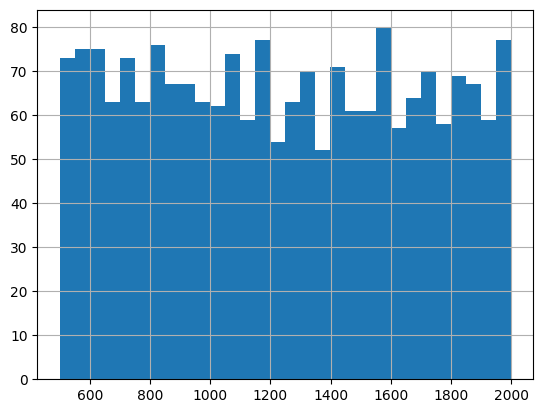

In [387]:
df['battery_power'].hist(bins=30)

In [388]:
df['battery_power'] = pd.cut(df['battery_power'], bins=[501, 800, 1200, 1600, 1998])
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,"(800, 1200]",0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,"(800, 1200]",1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,"(501, 800]",1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,"(501, 800]",1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,"(1600, 1998]",1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


<Axes: xlabel='battery_power'>

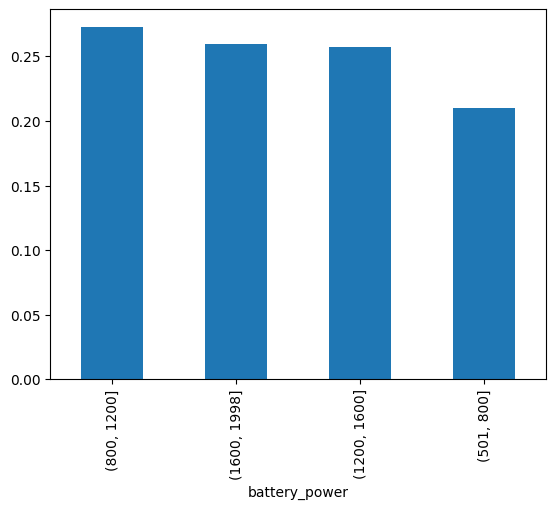

In [389]:
df['battery_power'].value_counts(normalize=True).plot.bar()

<Axes: xlabel='battery_power'>

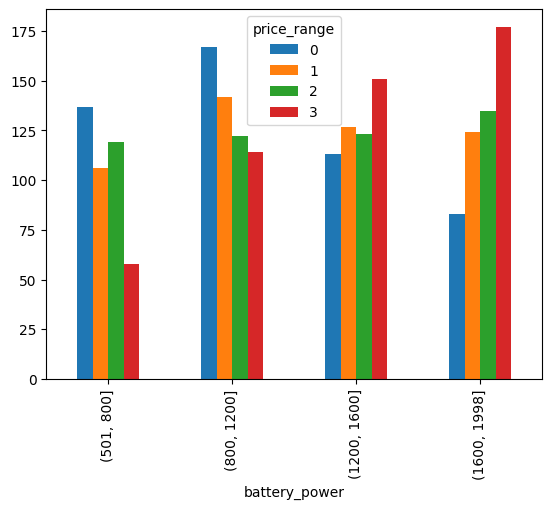

In [390]:
df.groupby(['battery_power', 'price_range']).size().unstack(fill_value=0).plot.bar()

<Axes: xlabel='battery_power'>

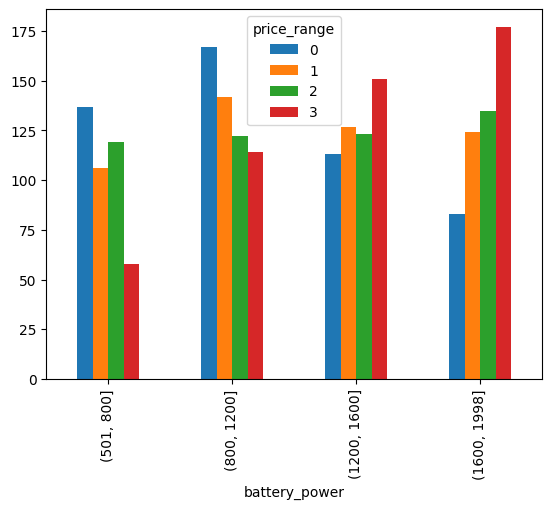

In [393]:
pd.crosstab(df['battery_power'], df['price_range']).plot.bar()

# Notes

In [391]:
"""
------ Parità di genere
m_mask = x_test[feature_name] == m_label
f_mask = x_test[feature_name] == f_label
xm_test, ym_test = x_test[m_mask], y_test[m_mask]
xf_test, yf_test = x_test[f_mask], y_test[f_mask]
m_pred = evaluate_classifier(model, xm_test, ym_test, 'Male')
f_pred = evaluate_classifier(model, xf_test, yf_test, 'Female')

# !! If prediction is BINARY !!
print(f'Predicted "{y_test.name}" probability:')
print(f'Male:       {((m_pred.sum() / m_pred.size) * 100).round(2)}%')
print(f'Female:     {((f_pred.sum() / f_pred.size) * 100).round(2)}%')

------ Cross-Validation
cv = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"\nMedia Accuracy 5-Fold CV: {cv.mean():.4f}")
#cv è il numero di fold, accuracy la metrica da valutare.
#Confronto: La CV è solitamente più rappresentativa della Confusion Matrix perché testa il modello su diverse porzioni del dataset, riducendo il rischio di overfitting su uno specifico split di test.


------ Cross-Validation e Pipeline
# 1. Creiamo la pipeline: prima scala i dati, poi applica la LR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', log_reg) # log_reg è il modello definito in precedenza
])
# 2. Passo la pipeline alla cross_val_score invece del singolo modello
cv = cross_val_score(pipeline, X, y, cv=10, scoring='accuracy')
print(f"\nMedia Accuracy 10-Fold CV (con Scaling): {cv.mean():.4f}")


------ Train-Test split
X = dataset.drop('target', axis=1).drop(get_categorical_features(dataset), axis=1)
y = dataset['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/5, random_state=0
)


------ Scaler
# Dovresti preoccuparti dello scaling (e quindi del MaxAbsScaler o StandardScaler) solo quando usi: Logistic Regression (per far convergere il solutore); SVM / KNN (perché si basano sulle distanze); Reti Neurali (per la stabilità del gradiente); PCA (perché si basa sulla varianza).
scaler = StandardScaler()
#oppure
# scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


------ Allenare Logistic Regression
log_reg = LogisticRegression(max_iter=1000,random_state=42)
log_reg.fit(X_train, y_train)


------- Allenare Decision Tree
dec_tree = DecisionTreeClassifier(random_state=42)  
dec_tree.fit(X_train, y_train)


------- Allenare Random Forest
rand_forest = RandomForestClassifier(n_estimators=100, random_state=42)
rand_forest.fit(X_train, y_train)


------- Allenare Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


------- Grid Search CV
# 1. Definizione dei parametri da testare
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10, 20]
}
# 2. Creazione del classificatore base
dt_base = DecisionTreeClassifier(random_state=0)
# 3. Configurazione della GridSearchCV (cv=10 per coerenza con il punto precedente)
grid_search = GridSearchCV(estimator=dt_base, param_grid=param_grid, cv=10, scoring='accuracy')
# 4. Ricerca sui dati di train
grid_search.fit(X_train, y_train)
# 5. Risultati migliori:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Migliori parametri trovati: {best_params}")
print(f"Accuracy media in CV (Migliore): {best_score:.4f}")

"""

'\n------ Parità di genere\nm_mask = x_test[feature_name] == m_label\nf_mask = x_test[feature_name] == f_label\nxm_test, ym_test = x_test[m_mask], y_test[m_mask]\nxf_test, yf_test = x_test[f_mask], y_test[f_mask]\nm_pred = evaluate_classifier(model, xm_test, ym_test, \'Male\')\nf_pred = evaluate_classifier(model, xf_test, yf_test, \'Female\')\n\n# !! If prediction is BINARY !!\nprint(f\'Predicted "{y_test.name}" probability:\')\nprint(f\'Male:       {((m_pred.sum() / m_pred.size) * 100).round(2)}%\')\nprint(f\'Female:     {((f_pred.sum() / f_pred.size) * 100).round(2)}%\')\n\n------ Cross-Validation\ncv = cross_val_score(model, X, y, cv=5, scoring=\'accuracy\')\nprint(f"\nMedia Accuracy 5-Fold CV: {cv.mean():.4f}")\n#cv è il numero di fold, accuracy la metrica da valutare.\n#Confronto: La CV è solitamente più rappresentativa della Confusion Matrix perché testa il modello su diverse porzioni del dataset, riducendo il rischio di overfitting su uno specifico split di test.\n\n\n------ Cro